<a href="https://colab.research.google.com/github/ever-oli/MLby22/blob/main/StockPricePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-4057452833.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2019-01-01", end="2026-01-01")
[*********************100%***********************]  1 of 1 completed

Executing on device: cpu

Dataset loaded: 1760 trading days.

Engineering temporal features...

Commencing LSTM Training...


Epoch [10/50], MSE Loss: 0.002036
Epoch [20/50], MSE Loss: 0.002367
Epoch [30/50], MSE Loss: 0.001687
Epoch [40/50], MSE Loss: 0.001814
Epoch [50/50], MSE Loss: 0.002126

Evaluating model performance...
FINAL MODEL METRICS
Directional Accuracy: 47.88%
Note: A random guess sits at ~50%. Anything above 55% in highly volatile stocks is statistically significant.



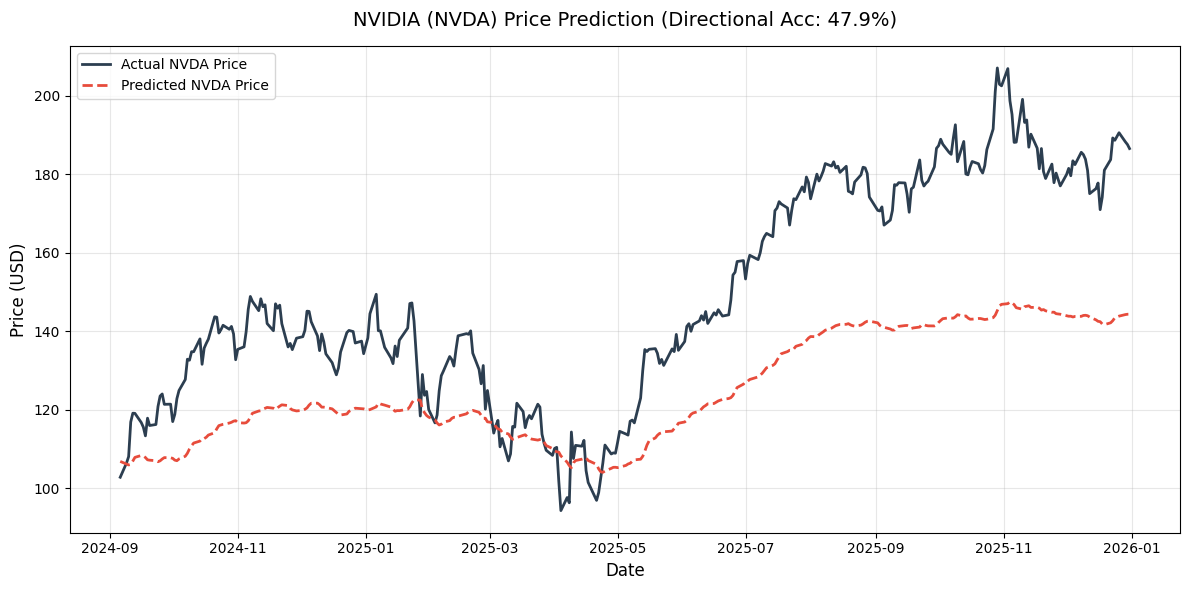

In [3]:

# TIME SERIES FORECASTING: NVIDIA (NVDA) WITH PYTORCH LSTM & DIRECTIONAL METRICS

# Run this cell to install required libraries:
# !pip install yfinance torch numpy pandas matplotlib scikit-learn -q

import yfinance as yf
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Executing on device: {device}\n")


# 1. Data Ingestion via yfinance

ticker = "NVDA"
print(f"Downloading historical data for {ticker}...")
df = yf.download(ticker, start="2019-01-01", end="2026-01-01")

print(f"Dataset loaded: {df.shape[0]} trading days.\n")


# 2. Time Series Feature Engineering

print("Engineering temporal features...")

# Trend indicators
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Momentum indicator
df['Daily_Return'] = df['Close'].pct_change()

# Seasonality encoding
df['DayOfYear'] = df.index.dayofyear
df['DayOfYear_Sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
df['DayOfYear_Cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)

df.dropna(inplace=True)

features = ['Close', 'MA_20', 'MA_50', 'Daily_Return', 'DayOfYear_Sin', 'DayOfYear_Cos']
data_subset = df[features].values


# 3. Data Scaling and Sequence Generation

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_subset)

close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(df[['Close']])

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Chronological Train/Test Split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


# 4. PyTorch LSTM Architecture

class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(StockLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

input_dim = len(features)
hidden_dim = 64
num_layers = 2
output_dim = 1

model = StockLSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 5. Training Loop

print("\nCommencing LSTM Training...")
epochs = 50

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for seqs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(seqs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], MSE Loss: {epoch_loss/len(train_loader):.6f}')


# 6. Evaluation, Directional Accuracy & Visualization

print("\nEvaluating model performance...")
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy()
    actuals = y_test_tensor.cpu().numpy()

predictions_dollar = close_scaler.inverse_transform(predictions)
actuals_dollar = close_scaler.inverse_transform(actuals)

# --- Calculating Directional Accuracy ---
# To know the direction, we compare today's prediction with yesterday's actual price
# We slice arrays from index 1 onward for the current day, and index 0 to -1 for yesterday
actual_deltas = actuals_dollar[1:] - actuals_dollar[:-1]
predicted_deltas = predictions_dollar[1:] - actuals_dollar[:-1]

actual_direction = np.sign(actual_deltas)
predicted_direction = np.sign(predicted_deltas)

# Calculate the percentage of times the model correctly guessed 'up' or 'down'
correct_directions = np.sum(actual_direction == predicted_direction)
directional_accuracy = correct_directions / len(actual_direction)

print("=" * 45)
print("FINAL MODEL METRICS")
print("=" * 45)
print(f"Directional Accuracy: {directional_accuracy * 100:.2f}%")
print("Note: A random guess sits at ~50%. Anything above 55% in highly volatile stocks is statistically significant.")
print("=" * 45 + "\n")

# --- Plotting the Results ---
plt.figure(figsize=(12, 6))
test_dates = df.index[-len(actuals):]

plt.plot(test_dates, actuals_dollar, color='#2c3e50', label='Actual NVDA Price', linewidth=2)
plt.plot(test_dates, predictions_dollar, color='#e74c3c', label='Predicted NVDA Price', linewidth=2, linestyle='--')
plt.title(f'NVIDIA (NVDA) Price Prediction (Directional Acc: {directional_accuracy * 100:.1f}%)', fontsize=14, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()